<div style="text-align: right" align="right"><i>Peter Norvig, 2015–2025</i></div>

# The Traveling Salesperson Problem

[![](http://support.sas.com/documentation/cdl/en/ornoaug/66084/HTML/default/images/map002g.png)](http://www.math.uwaterloo.ca/tsp/history/pictorial/dfj.html)


Consider the [***Traveling Salesperson Problem***](http://en.wikipedia.org/wiki/Traveling_salesman_problem) (abbreviated ***TSP***): 

➜ *Given a **set of cities** and the **distance** between each pair of cities, what is the **shortest** **tour**  that visits each city exactly once, and returns to the starting city?*

Solutions to this problem are used in [serious applications](https://research.googleblog.com/2016/09/the-280-year-old-algorithm-inside.html) that millions of people rely on every day. 
In this notebook we will develop some different algorithms that solve the problem, and more generally show *how to think about* solving  problems. Then we'll benchmark the algorithms, comparing them for run time and tour length. 


# Implementation of Basic Concepts

I'll go through the definition again and make implementation choices for each concept:

- *Given a set of cities*
    - A **set of cities** can be represented with a Python `set` of points on the (*x*, *y*) plane. I'll use a `frozenset`, a set that can't be changed.
- *and the distance between each pair of cities*,
    - The **distance** between two points in a plane is  the [**Euclidean distance**](http://en.wikipedia.org/wiki/Euclidean_distance). I'll use a function `distance(A, B)`. 
- *what is the shortest*
    - I'll us `shortest(tours)` to find this, and `tour_length(tour)` for the length of a single tour.
- *tour*
    -  A **tour** will be represented by a list. `[A, B, C]` is the tour from `A` to `B` to`C` and back to `A` .   
- *that visits each city exactly once, and returns to the starting city?*
    - The function `valid_tour(tour)` implements this.

Four more basic concepts, implied by the definition:

- **City**: At first glance, Python does not seem to have a builtin type for point in the (*x*, *y*) plane. But  there is a type we can use: [complex numbers](https://docs.python.org/3/c-api/complex.html), which are points in the (*real* × *imaginary*) plane.
- **Link**: A tour consists of a sequence of **links** between cities. A link can be represented implicitly by the adjacency of two cities in a tour, or explicitly by an `[A, B]` pair of cities.
- **Segment**: A portion of a tour that does not loop back to the start. The **segment** `[A, B, C]` has only two links, A-B and B-C, whereas the **tour** `[A, B, C]` has three links, A-B, B-C, and C-A.
- **TSP algorithm**: A function with the signature `tsp(cities: Cities) -> Tour`.

Notes: some authors use "cycle" or "circuit" or "[Hamiltonian path](https://en.wikipedia.org/wiki/Hamiltonian_path)" instead of "tour." The Euclidean distance measure is **symmetric** (the distance from `A` to `B` is the same as the distance from `B` to `A`). But not all distance metrics are like this. If you have to follow roads rather than straight lines, the distance is at the whim of the road-builders. Perhaps the distance from `A` to `B` is different than the distance from `B` to `A` because of one-way streets.  Almost everything in this notebook still holds with a different distance function; I'll  point out where it doesn't.

First some imports (they will be explained later as they are used):

In [1]:
import functools
import itertools
import random
import time  
import math
import re
import matplotlib.pyplot as plt      
from collections import Counter
from statistics  import mean, median, stdev
from typing      import Set, List, Tuple, Iterable, Callable
from dataclasses import dataclass

Now the implementation of the basic concepts:

In [2]:
City    = complex   # e.g. City(300, 100)
Cities  = frozenset # A set of cities
Tour    = list      # A list of cities to visit, in order
TSP     = Callable  # A TSP algorithm is a callable function
Segment = list      # A portion of a tour; it does not loop back to the start.
Link    = list      # A [city, city] link


def distance(A: City, B: City) -> float: 
    """Distance between two cities"""
    return abs(A - B)

def shortest(tours: Iterable[Tour]) -> Tour: 
    """The tour with the smallest tour length."""
    return min(tours, key=tour_length)

def tour_length(tour: Tour) -> float:
    """The total distances of each link in the tour, including the link from last back to first."""
    return sum(distance(tour[i], tour[i - 1]) for i in range(len(tour)))

def valid_tour(tour: Tour, cities: Cities) -> bool:
    """Does `tour` visit every city in `cities` exactly once?"""
    return sorted(tour) == sorted(cities)

# Sets of Random Cities

To test TSP algorithms, I'll need sets of cities. I'll define `random_cities(n)` to return a set of `n` cities, sprawled out randomly over the map. 

*Note*: I'll eventually want to be able to do reproducible comparisons of algorithms: to run two or more algorithms on the same set of cities. Therefore `random_cities` has an optional argument, `seed`, with a default value. If you pass in the same seed, you will get back the same set of cities.  If you want a different set of *n* random cities, pass in a different seed.

In [3]:
def random_cities(n, seed=1234, width=3000, height=2000) -> Cities:
    "Make a set of n cities, sampled uniformly from a (width x height) rectangle."
    random.seed((n, seed)) # For reproducibility
    return Cities(City(random.randrange(width), random.randrange(height))
                  for c in range(n))

# Exhaustive TSP Search Algorithm (exhaustive_tsp)

Let's start with an algorithm that is *guaranteed* to find the shortest tour, although inefficiently:

- **Exhaustive TSP Search Algorithm**: *Generate all possible tours of the cities, and choose the shortest one.*

My design philosophy is to first write an English description of the algorithm (as above), then write Python code that closely mirrors the English description:

In [4]:
def exhaustive_tsp(cities) -> Tour:
    "Generate all possible tours of the cities and choose the shortest one."
    return shortest(possible_tours(cities))

I note that the possible tours are just the permutations of the set of cities, and `permutations` is defined in the `itertools` module, so we get:

In [5]:
possible_tours = itertools.permutations 

Let's try it on a random set of 8 cities:

In [6]:
exhaustive_tsp(random_cities(8))

((1174+1935j),
 (1675+1135j),
 (2078+1173j),
 (2382+1608j),
 (2731+287j),
 (2436+237j),
 (2220+81j),
 (1053+480j))

Quick, is that the shortest tour?  I can't tell, and I bet you can't either. But if I plotted the points on a map, maybe we would be enlightened.

# Visualizing results (plot_tour)

I'll define `plot_tour` to plot all the cities and links in a tour, highlighting the first city. 

In [7]:
def plot_tour(tour: Tour, style='bo-', hilite='rD'): 
    "Plot every city and link in the tour, and highlight the start city."
    scale = 1 + len(tour) ** 0.5 // 10 # More cities, bigger size figure
    plt.figure(figsize=((3 * scale, 2 * scale)))
    start = tour[0]
    plot_segment([*tour, start], style)
    plot_segment([start], hilite) 
    
def X_(city: City)   -> float: "X coordinate";  return city.real
def Y_(city: City)   -> float: "Y coordinate";  return city.imag
def Xs(cities) -> List[float]: "X coordinates"; return list(map(X_, cities))
def Ys(cities) -> List[float]: "Y coordinates"; return list(map(Y_, cities))

def plot_segment(segment: Segment, style='bo:'):
    "Plot every city and link in the segment."
    plt.plot(Xs(segment), Ys(segment), style, linewidth=2/3, markersize=5, clip_on=False)
    plt.axis('scaled'); plt.axis('off')

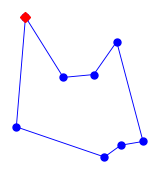

In [8]:
plot_tour(exhaustive_tsp(random_cities(8)))

The plot helps convince me that this is indeed the shortest tour.


I will define the function `run` to run a TSP algorithm on a set of cities and optionally plot the tour. It returns a `Run` object, which packages up the resulting tour and the run time, and has a pretty representation).

In [9]:
def run(tsp: callable, cities: Cities, plot=True):
    """Run a TSP algorithm on a set of cities and plot the results if `plot` is true."""
    t0   = time.perf_counter()
    tour = tsp(cities)
    t1   = time.perf_counter()
    if plot:
        plot_tour(tour)
    return Run(tour, t1 - t0, tsp)

class Run:
    """The tour found by a run and the time it took to compute it, with a pretty representation."""
    def __init__(self, tour, seconds, tsp):
        self.tour = tour
        self.msec = 1000 * seconds
        self.name = tsp.__name__
        self.length = tour_length(tour)
    def __repr__(self): 
        return f"{self.name}({len(self.tour)} cities) ⇒ {self.length:,.0f} length tour in {self.msec:,.0f} msecs"

Here is `run` in action:

exhaustive_tsp(8 cities) ⇒ 6,505 length tour in 106 msecs

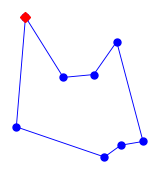

In [10]:
run(exhaustive_tsp, random_cities(8))

# Speedup for  possible_tours

The number of possible tours of *n* cities is the number of permutations, which is *n*! (the factorial of *n*), and thus there are  6 tours of 3 cities:

In [11]:
list(possible_tours({1, 2, 3}))

[(1, 2, 3), (1, 3, 2), (2, 1, 3), (2, 3, 1), (3, 1, 2), (3, 2, 1)]

But a tour is a loop, so `(1, 2, 3)`, `(2, 3, 1)`, and `(3, 1, 2)` are three ways of describing exactly the same loop. I can redefine `possible_tours` to only include one representation of each loop by arbitrarily saying that a tour must start with the first city in the set of cities.  

In [12]:
def possible_tours(cities) -> List[Tour]:
    "Return a list of non-redundant tours (permutations of cities with first city first)."
    start, *others = cities
    return [[start, *perm] for perm in itertools.permutations(others)]

We can verify that for 3 cities there are now only 2 tours, not 6:

In [13]:
possible_tours({1, 2, 3})

[[1, 2, 3], [1, 3, 2]]

We can see that `exhaustive_tsp` can now do 9 cities in roughly the time it took to do 8 before:

exhaustive_tsp(9 cities) ⇒ 6,900 length tour in 183 msecs

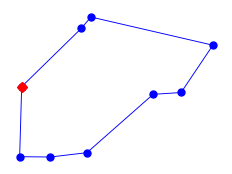

In [14]:
run(exhaustive_tsp, random_cities(9))

We can keep going to 10 cities, which takes about a second:

exhaustive_tsp(10 cities) ⇒ 7,675 length tour in 1,021 msecs

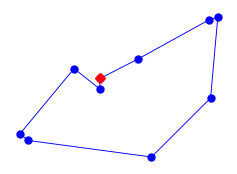

In [15]:
run(exhaustive_tsp, random_cities(10))

# General Strategies for Algorithm Design

It takes Exhaustive Search a second or so to solve a 10-city problem, so 12 cities would take about 2 minutes (11×12 times longer), and 15 cities would take days. 
There must be a better way ... 

To get inspired, here are some general  strategies for algorithm design: 

* **Brute Force Strategy**: The strategy used for `exhaustive_tsp`; as [Ken Thompson](https://en.wikipedia.org/wiki/Ken_Thompson) [says](https://www.brainyquote.com/quotes/ken_thompson_185574?src=t_brute_force), "*when in doubt, use brute force*."
* **Approximation Strategy**: If it is too hard to find an exact, optimal solution, consider an approximate, slightly suboptimal solution.
* **Greeedy Strategy**: To complete a multiple step problem, first do the step that appears to be best in the short run. Repeat. 
* **Local Search Strategy**: Create a solution, then check if small local edits improve it.
* **Divide and Conquer Strategy**: Split the problem in half, solve each half, and combine the two partial solutions.
* **Ensemble Strategy**: Let a set of algorithms each try the problem, and pick the best solution. 
* **Stand on the Shoulders of Giants Strategy**: Find out what other people have done, and copy them.

Let's apply these strategies to develop some TSP algorithms. We'll make a quick journey through the various algorithms, and then step back to test them on a series of benchmarks.


#  Nearest Neighbor Algorithm (nearest_tsp)

Here's a second TSP algorithm:

- **Nearest Neighbor TSP Algorithm:** *Create a partial tour that initially is just the start city. At each step extend the partial tour to the nearest unvisited neighbor of the last city in the partial tour, until there are no unvisited cities remaining.*

This is both an **approximation strategy** and a **greedy strategy**. It is an approximation, because it won't necessarily find the optimal tour. It is greedy because at each step it makes the choice that looks best in the short run (the nearest neighbor), even if that is not the best in the long run.



In [16]:
def nearest_tsp(cities: Cities, start:City=None) -> Tour:
    """Create a partial tour that initially is just the start city. 
    At each step extend the partial tour to the nearest unvisited neighbor 
    of the last city in the partial tour, while there are unvisited cities remaining."""
    tour = [start or first(cities)]
    unvisited = set(cities) - set(tour)
    while unvisited:     
        nearest = min(unvisited, key=lambda C: distance(C, tour[-1]))
        tour.append(nearest)
        unvisited.remove(nearest)
    return tour

def first(items): 
    """The first element of a collection or iterable."""
    return next(iter(items))

The exhaustive search considers all tours, so the run time for *n* cities is proportional to *n*! and [we say](https://en.wikipedia.org/wiki/Big_O_notation) it is *O*(*n*!). The nearest neighbor algorithm builds *n* links in the tour and at each step considers up to *n* possibilities, so we say it is *O*(*n*<sup>2</sup>). That means it runs a lot faster! While `exhaustive_tsp` could only do 10 cities in a second, `nearest_tsp` can do thousands. Here it is finding a tour of 3,000 cities in under a second:

nearest_tsp(3000 cities) ⇒ 119,082 length tour in 824 msecs

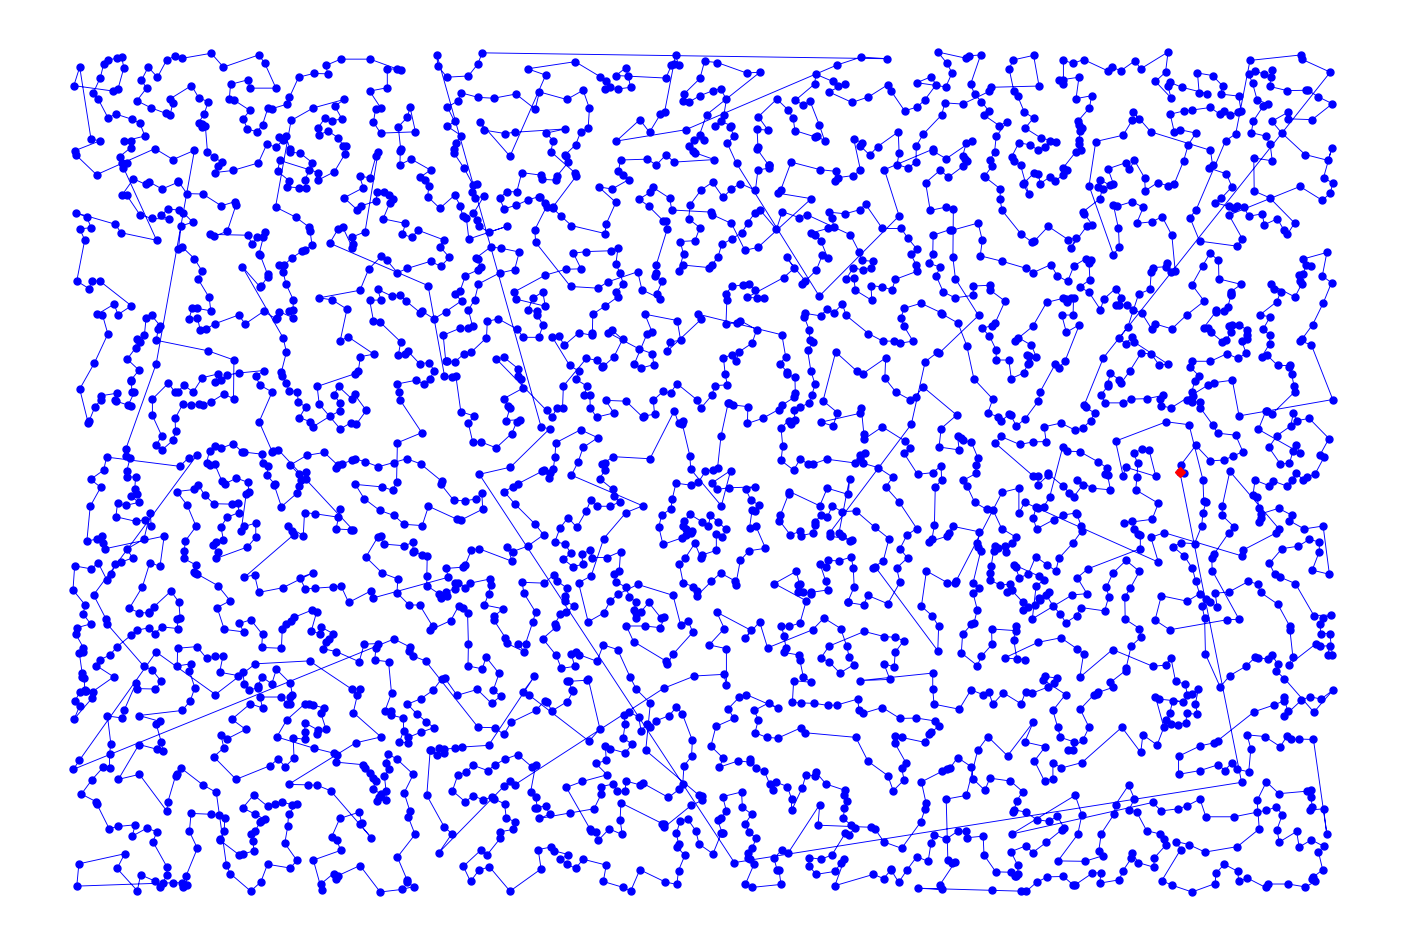

In [17]:
run(nearest_tsp, random_cities(3000))

# Real-World Cities

A tour of 3,000 random cities looks like a [Jackson Pollack](https://www.moma.org/artists/4675) painting.  I thought it would be fun to work on some *real* cities. I found a web page (now 404, but a copy is [here](https://raw.githubusercontent.com/norvig/pytudes/master/data/latlong.htm)) that lists coordinates of over 1000 cities in the USA, in this format:

     [TCL]  33.23   87.62  Tuscaloosa,AL
     [FLG]  35.13  111.67  Flagstaff,AZ
     [ANC]  61.17  150.02  Anchorage,AK

We can fetch the file if a local copy is not already in the current directory:

In [18]:
! [ -e latlong.htm ] || curl -O https://raw.githubusercontent.com/norvig/pytudes/refs/heads/main/data/latlong.htm

I define the function `parse_cities` to extract cities from a file in this format (skipping Alaska and Hawaii):

In [19]:
def parse_cities(text: str, skip=('AK', 'HI'), long_scale=-48, lat_scale=69) -> Cities:
    """Make a set of Cities from lines of text, skipping the specified states."""
    return Cities(City(int(long_scale * float(long)), int(lat_scale  * float(lat)))
                  for (lat, long, state) in re.findall(r'([\d.]+)\s+([\d.]+).+([A-Z][A-Z])', text)
                  if state not in skip)

USA = parse_cities(open('latlong.htm').read())

(You might be wondering about the `long_scale=-48, lat_scale=69` part. The issue is that computing distance from latitude and longitude requires [complicated trigonometry](http://en.wikipedia.org/wiki/Haversine_formula).  But we can get an approximation by assuming that latitude and longitude are on a flat rectangular grid. (This is a bad approximation if you're talking about links of 1,000 miles, but close enough for shorter links, as long as you're not too near the poles.)  I took the latitude of the center of the USA (Wichita, KS: latitude 37.65) and plugged it into a [Length Of A Degree Of Latitude
And Longitude Calculator](http://www.csgnetwork.com/degreelenllavcalc.html) to find that, in Wichita, one degree of latitude is 69 miles, and one degree of longitude is 48 miles.  I use -48 rather than +48 because the USA is west of the prime meridian.) 

I also found a [blog post](http://www.randalolson.com/2015/03/08/computing-the-optimal-road-trip-across-the-u-s/) by Randal S. Olson, who chose 50 landmarks across the USA and found a tour based on actual road-travel distances, not straight-line distance; I would need a new `distance` function to handle that. William Cook provides an
analysis, and a [tour that is shorter](http://www.math.uwaterloo.ca/tsp/usa50/index.html) than Randal's.

Now let's find a baseline nearest neighbor tour on the USA map:

nearest_tsp(1088 cities) ⇒ 53,364 length tour in 103 msecs

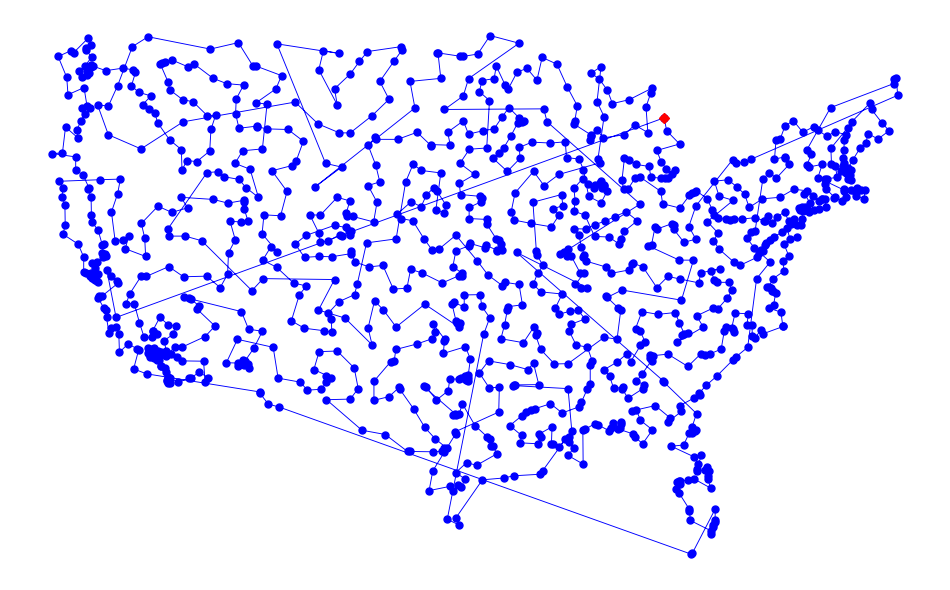

In [20]:
run(nearest_tsp, USA)

In some places this tour looks good, but there are a few very long links. They seem to leave room for improvement. In the next section we'll see how to improve a tour using a local search over the links.

# Local Search Strategy (two_opt)

In the top of the following diagram  (from [wikipedia](https://en.wikipedia.org/wiki/2-opt)) we see a part of a tour that has two crossed links forming an ╳. In the bottom we see the same tour with the ╳ uncrossed. Essentially we have replaced two longer crossed links with two shorter links, thus improving the tour.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b8/2-opt_wiki.svg/360px-2-opt_wiki.svg.png)


Could we modify a nearest-neighbor search to avoid making mistakes like the crossed links in the first place? That would be hard. When the tour is [a, b] it is not obvious that [a, b, e] is a mistake. it is only 3 links later when we make the [c, f] link that the problem becomes apparent.  So, rather than tackling the difficult task of **avoiding** mistakes, the **local search strategy** says to go ahead and make mistakes in creating the initial version of a tour, and then do the easier task of **fixing** the mistakes. Why is it easier to fix the mistakes? Because we can propose a change and get a definitive answer: either the change makes the whole tour shorter or it doesn't. 

When we are dealing with **Euclidean distance** (or any **[metric space](https://en.wikipedia.org/wiki/Metric_space)** for that matter), then by the [triangle inequality](https://en.wikipedia.org/wiki/Triangle_inequality) we can see that anytime there are two links that cross in an ╳ pattern, we should uncross the ╳. You can think of this as breaking two links and putting them back together in the opposite configuration, or you can think of it as reversing a segment of the tour: we reverse [e, d, c] to [c, d, e].

In the literature of TSP, this kind of improvement is called [**2-opt**](https://en.wikipedia.org/wiki/2-opt), because it involves deleting two links and replacing them with two optimized links. There is also a [**3-opt**](https://en.wikipedia.org/wiki/3-opt), which we won't cover, but you are welcome to look into it.

I'll define `two_opt(tour)` to consider various segments, and reverse a segment whenever that improves the tour. What segments should we consider? I don't know how to be clever about that, but I do know how to use **brute force**: try every subsegment. (I have an intuition (from experience with [simulated annealing](https://en.wikipedia.org/wiki/Simulated_annealing)) that trying longer subsegments first would be better, so I'll write `subsegments` that way.) After I've tried all segments, if one of them did improve the tour I'll repeat the process until there are no improvements, then return the improved tour:

In [21]:
def two_opt(tour: Tour) -> Tour:
    "Perform 2-opt segment reversals to optimize tour."
    tour = list(tour)
    while True:
        changed = False
        for (i, j) in subsegment_indexes(len(tour)):
            if reversal_is_improvement(tour, i, j):
                tour[i:j] = reversed(tour[i:j])
                changed = True
        if not changed:
            return tour
        
def reversal_is_improvement(tour, i, j) -> bool:
    "Would reversing the segment `tour[i:j]` make the tour shorter?" 
    # Given tour [...A,B...C,D...], would reversing B...C to C...B make the tour shorter?
    A, B, C, D = tour[i-1], tour[i], tour[j-1], tour[j % len(tour)]
    return distance(A, B) + distance(C, D) > distance(A, C) + distance(B, D)

cache = functools.lru_cache(None) # Or just `functools.cache` in Python 3.9+
        
@cache # All tours of length N have the same subsegment indexes, so cache them.
def subsegment_indexes(N) -> List[Tuple[int, int]]:
    "Return (i, j) index pairs denoting tour[i:j] subsegments of a tour of length N."
    return [(i, i + length)
            for length in reversed(range(2, N))
            for i in range(N - length)]

To see the power of 2-opt, let's apply it to a terrible tour: one formed from whatever random order the set of USA cities happen to fall into:

two_opt(1088 cities) ⇒ 46,460 length tour in 3,182 msecs

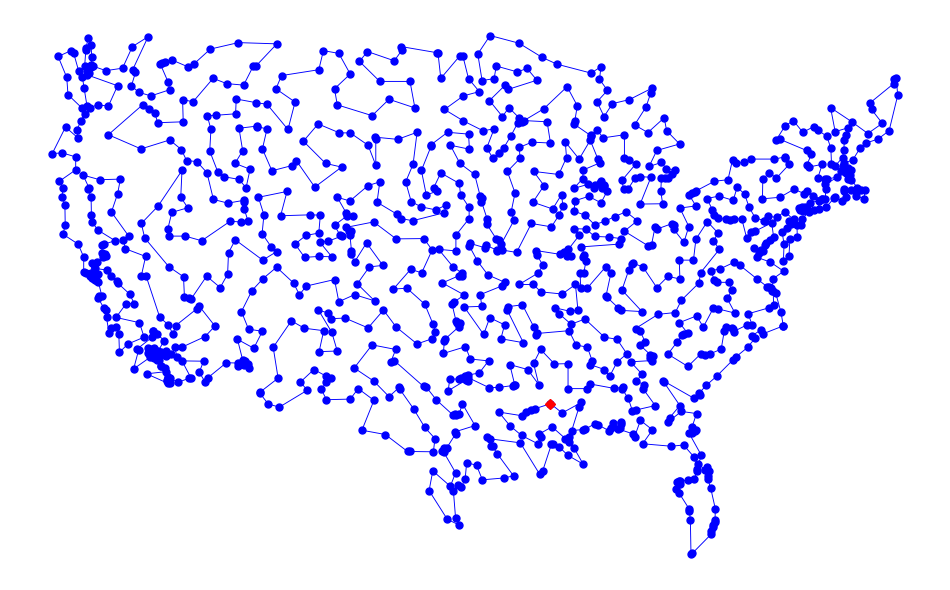

In [22]:
run(two_opt, list(USA))

Could we do better if we started with a bettert tour? I'll define `compose` so that  `compose(two_opt, nearest_tsp)` gives us a function that calls `two_opt` on the result of calling `nearest_tsp`:

In [23]:
def compose(f: Callable, g: Callable) -> Callable:
    """Return a function that calls f on the result of g."""
    fn = lambda x: f(g(x))
    fn.__name__ = f"{f.__name__}_{g.__name__}"
    return fn

two_opt_nearest_tsp(1088 cities) ⇒ 45,105 length tour in 2,075 msecs

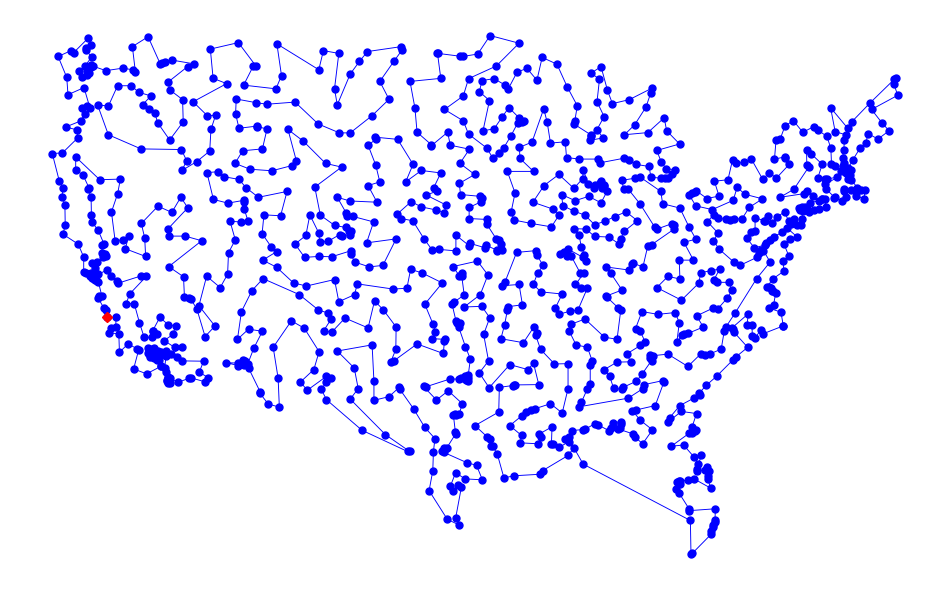

In [24]:
run(compose(two_opt, nearest_tsp), USA)

This tour is significantly shorter than what `nearest_tsp` alone yields (although the run time is longer). Later on we will **benchmark** our algorithms against a large test set of different maps, so we won't spend too much effort right now on comparing results.

# Greedy TSP Algorithm (greedy_tsp)

The Nearest Neighbor Algorithm followed the **greedy strategy** in always choosing the neighbor that is nearest to the previous city in the tour. Another way to be greedy is to always choose the shortest possible link, **anywhere** in the map, not just from the previous city in the partial tour. It works like this: 

> **Greedy Algorithm:** *Maintain a set of **segments**; intially each city defines its own 1-city segment. Find the shortest possible link that connects two endpoints of two different segments, and join those segments with that link. Repeat until we form a single segment that tours all the cities.*

On each step of the algorithm, we want to *"find the shortest possible link that connects two endpoints."* That seems like an expensive operation to do on each step. So we will add some data structures  to speed up the computation:  

1. Pre-compute a list of links, sorted by shortest link first. A link is two-city segment: `[A, B]`.
2. Maintain a dict that maps **endpoints** to **segments**, e.g. `{A: [A, B, C], C: [A, B, C], D: [D]}` means that `A` and `C` are the endpoints of segment `[A, B, C]` and `D` is the only endpoint of a 1-city segment. 
3. Go through the links in shortest-distance-first order. Given the dict listed above, suppose the next shortest link is:
    - `[B, D]`: Can't use it because `B` is in the middle of a segment; it is already attached to `A` and `C`  by shorter links. 
    - `[A, C]`: Can't use it; that would make `[A, B, C]` into a closed loop. 
    - `[C, D]`: Use it: join the two segments together, giving the updated endpoints dict: `{A: [A, B, C, D], D: [A, B, C, D]}`.
4. Stop when the newly created segment contains all the cities.

Here is the code:

In [25]:
def greedy_tsp(cities):
    """Go through links, shortest first. If a link can join segments, do it."""
    endpoints = {C: [C] for C in cities} # A dict of {endpoint: segment}
    for [A, B] in shortest_links_first(cities):
        if A in endpoints and B in endpoints and endpoints[A] != endpoints[B]:
            joined_segment = join_segments(endpoints, A, B)
            if len(joined_segment) == len(cities):
                return joined_segment
            
def shortest_links_first(cities) -> List[Link]:
    "Return all links between cities, sorted shortest first."
    return sorted(itertools.combinations(cities, 2), key=lambda link: distance(*link))
            
# TODO: join_segments

**Note:** The `endpoints` dict serves two purposes. First, the keys of the dict are cities that are endpoints of some segment, making it possible to ask "`A in endpoints`" to see if city `A` is an endpoint. Second, the value of `endpoints[A]` is the segment that `A` is an endpoint of, making it possible to ask "`endpoints[A] != endpoints[B]`" to make sure that the two cities are endpoints of different segments, not of the same segment (we don't want to join a segment to itself and form a loop).

For the `join_segments` function, I first make sure that `A` is the last element of one segment and `B` is the first element of the other, by reversing segments if necessary.  Then I add the B segment on to the end of the A segment. Finally, I update the `endpoints` dict by deleting `A` and `B` and then adding the two endpoints of the new segment: 

In [26]:
def join_segments(endpoints: dict, A: City, B: City) -> Segment:
    "Join segments [...,A] + [B,...] into one segment. Maintain `endpoints`."
    Aseg, Bseg = endpoints[A], endpoints[B]
    # Make sure that Aseg ends in A and Bseg begins with B:
    if Aseg[0] is A and Bseg[-1] is B: 
        A, B = B, A        # Swap A and B
    if Aseg[-1] is not A:
        Aseg.reverse()     # Make sure Aseg ends in A
    if Bseg[0]  is not B:
        Bseg.reverse()     # Make sure Bseg begins with B
    Aseg += Bseg
    # Maintain endpoints dict:
    del endpoints[A], endpoints[B] 
    endpoints[Aseg[0]] = endpoints[Aseg[-1]] = Aseg
    return Aseg

Hee is the greedy search in action:

greedy_tsp(1088 cities) ⇒ 51,129 length tour in 417 msecs

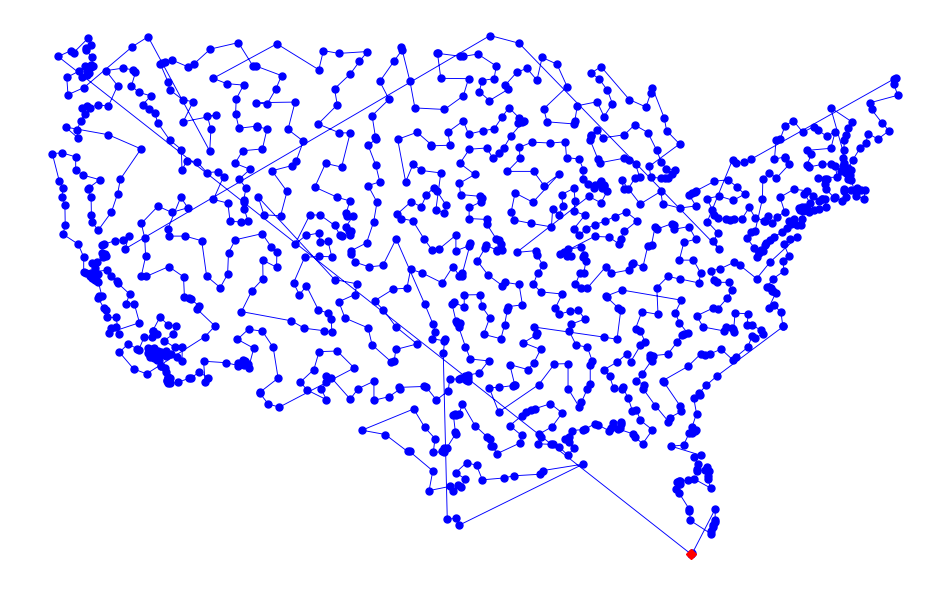

In [27]:
run(greedy_tsp, USA)

# Divide and Conquer (divide_tsp)

The next general strategy to consider is **divide and conquer**.  Given a  large problem, we can divide it into two smaller pieces, solve the two pieces, and then combine them:

1. Split the set of cities in half.
2. Find a tour for each half.
3. Join those two tours into one.

When the number of cities is small, step 2 can be done directly by the exhaustive search algorithm.  But when it is large, step 2 is done with a recursive call, breaking each half into two smaller pieces. 

Now we have a feel for what we have to do.  I'll name the divide and conquer algorithm `divide_tsp`:

In [28]:
def divide_tsp(cities, small=5) -> Tour:
    """Find a tour by divide and conquer: if number of cities is small, solve directly;
    otherwise split the cities in half, solve each half recursively, and join the two tours together."""
    if len(cities) <= small:
        return exhaustive_tsp(cities)
    else:
        half1, half2 = split_cities(cities)
        return join_tours(divide_tsp(half1, small), divide_tsp(half2, small))
    
# TODO: split_cities, join_tours

How do we split a set of cities?  In the non-Euclidean case, there would be no easy way to make a good split. But with each city having *x* and *y* coordinates, 
my approach is to imagine drawing an axis-aligned rectangle that is just big enough to contain all the cities. If the rectangle  is wider than it is tall, then order all the cities by *x* coordinate and split that ordered list in half.  If the rectangle is taller than it is wide, order and split the cities by *y* coordinate. 

In [29]:
def split_cities(cities) -> Tuple[List[City], List[City]]:
    "Split cities vertically if map is wider; horizontally if map is taller."
    X_or_Y  = (X_ if (extent(Xs(cities)) > extent(Ys(cities))) else Y_)
    cities = sorted(cities, key=X_or_Y)
    middle = len(cities) // 2
    return cities[:middle], cities[middle:]

def extent(numbers) -> float: return max(numbers) - min(numbers)

Here's the first split of USA:

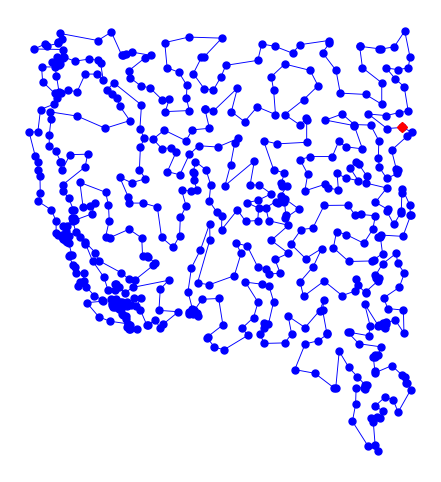

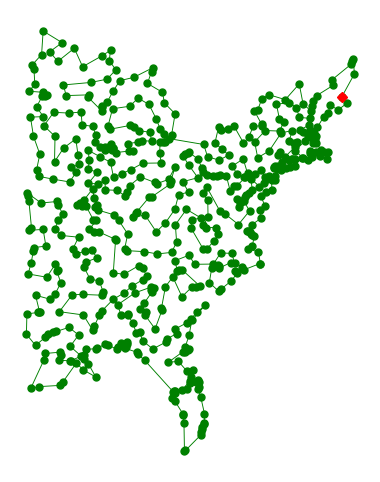

In [30]:
west, east = split_cities(USA)
plot_tour(two_opt(west), 'bo-')
plot_tour(two_opt(east), 'go-')

Now for the tricky part: joining two tours together. To do that, we need to consider all possible ways to break one link from each of the two tours to get two segments, and then join the segements together.

The set of possible segments of a tour are the rotations of the tour:  If you remove one link from the tour `[A, B, C]` you get the three segments:

     [C, A, B],  [A, B, C],  [B, C, A]

So any candidate combined tour consists of taking a rotation of the first tour, and appending to it a rotation of the second tour, with one caveat: when we go to append the two segments, there are two ways of doing it: either keep the second segment as is, or reverse the second segment.

In [31]:
def join_tours(tour1, tour2):
    "Consider all ways of joining the two tours together, and pick the shortest."
    segments1, segments2 = rotations(tour1), rotations(tour2)
    return shortest(s1 + s3
                    for s1 in segments1
                    for s2 in segments2
                    for s3 in (s2, s2[::-1]))

def rotations(sequence):
    "All possible rotations of a sequence."
    # A rotation is some suffix of the sequence followed by the rest of the sequence.
    return [sequence[i:] + sequence[:i] for i in range(len(sequence))]

The `divide_tsp` algorithm, as I have written it, is slow because it explicitly creates intermediate segments. It would be faster to compute the shortest combined tour by just looking locally at the changed links, but that would make the code less clear, so I leave that as an exercise for the interested leader. For now, rather than use the USA map, I'll use a sample of 200 cities:

divide_tsp(200 cities) ⇒ 32,481 length tour in 963 msecs

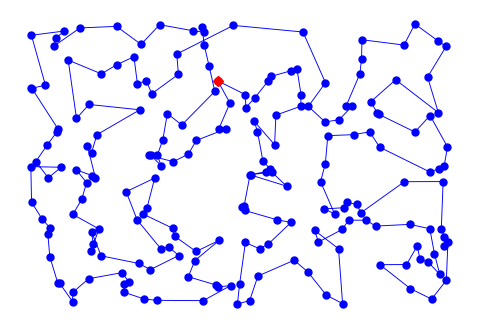

In [32]:
run(divide_tsp, random_cities(200))

# Shoulders of Giants: Minimum Spanning Tree Algorithm

I hope you feel that you could have come up with some ideas for solving the TSP, using the set of **strategies**. But even if you can't come up with something all on your own, you can follow the **Stand on the Shoulders of Giants Strategy**, also known as the **[Just Google it Strategy](http://bit.ly/XNGt2y)**, in which case you'll no doubt find a giant of a mathematician, [Joseph Kruskal](http://en.wikipedia.org/wiki/Joseph_Kruskal), who, in 1956, published [a paper](http://www.cmat.edu.uy/~marclan/TAG/Sellanes/Kruskal.pdf) that led to an algorithm that
most people would not have thought of on their own (I know I wouldn't have):

> **Minimum Spanning Tree Traversal Algorithm:** *Construct a Minimum Spanning Tree, then do a pre-order traversal.  That will give you a tour that is guaranteed to be no more than twice as long as the minimal tour.* 

What does all this jargon mean? It is part of *[graph theory](https://en.wikipedia.org/wiki/Graph_theory)*.  Here is a glossary of terms:

* A **graph** is a collection of vertexes and links.
* A **vertex** is a point (such as a city).
* A **link** is an edge between two vertexes. Links have lengths.
* A **directed graph** is a graph where the links have a direction.  We say that the link goes from the **parent** vertex to the **child** vertex.
* A **tree** is a directed graph in which there is one distinguished vertex called the **root** that has no parent; every other vertex has exactly one parent. 
* A **spanning tree** (of a set of vertexes) is a tree that contains all the vertexes.    
* A **minimum spanning tree** is a spanning tree with the smallest  sum of link lengths.
* A **traversal** of a tree is a way of visiting all the vertexes in some order.
* A **pre-order traversal** means that you visit the root first, then do a pre-order traversal of each of the children.


We will implement a directed graph as a dict of `{parent: [child, ...]}`. Now our plan is:

1. Implement an algorithm to create a minimum spanning tree, `mst`.
2. Implement a tree traversal; that will give us our `mst_tsp` algorithm.
3. Understand the guarantee.

## Creating a Minimum Spanning Tree: mst

Now let's see how to create a minimum spanning tree (or MST).  Kruskal has a very nice algorithm to find MSTs, but with what we have done so far, it will be a bit easier to implement [another Giant](https://en.wikipedia.org/wiki/Robert_C._Prim)'s algorithm:

> **[Prim's algorithm for creating a MST](http://en.wikipedia.org/wiki/Prim%27s_algorithm):** *List all the links and sort them, shortest first.  Initialize a tree to be a single root city (we'll arbitrarily choose the first city). Now repeat the following until the tree contains all the cities: find the shortest link that links a city (A) that is in the tree to a city (B) that is not yet in the tree, and add B to the list of A's children in the tree.*

Here's the code. One tricky bit: In the first line inside the `while` loop, we assign `(A, B)` to be a link in which exactly one of `A` or `B` is in the tree, using the exclusive-or operator, `^`.  Then in the next line, we make sure that `A` is the one that is in the tree and B is not, by swapping if necessary.

In [33]:
def mst(vertexes):
    """Given a set of vertexes, build a minimum spanning tree: a dict of the form 
    {parent: [child...]}, spanning all vertexes."""
    tree  = {first(vertexes): []} # the first city is the root of the tree.
    links = shortest_links_first(vertexes)
    while len(tree) < len(vertexes):
        [A, B] = first([A, B] for [A, B] in links if (A in tree) ^ (B in tree))
        if A not in tree: 
            A, B = B, A
        tree[A].append(B)
        tree[B] = []
    return tree

Let's see what a minimum spanning tree looks like. We'll need a new plotting function:

In [34]:
def plot_graph(graph) -> float:
    "Given a graph of the form {parent: [child...]}, plot vertexes and links."
    vertexes = {v for parent in graph for v in graph[parent]} | set(graph)
    links    = ((parent, child) for parent in graph for child in graph[parent])
    if len(graph) > 1000: 
        plt.figure(figsize=(15, 7.5))
    for link in links:
        plot_segment(link, 'go-')

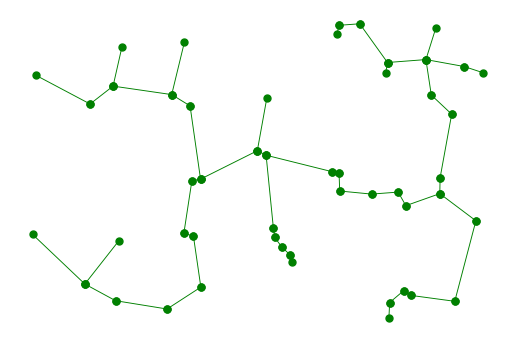

In [35]:
plot_graph(mst(random_cities(50)))

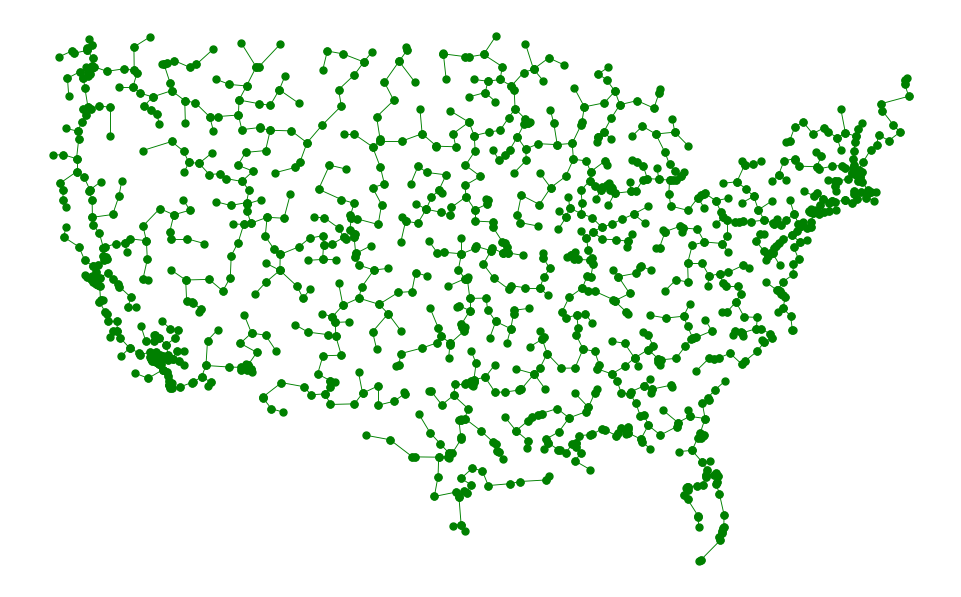

In [36]:
plot_graph(mst(USA))

This certainly looks like a spanning tree.  But can we prove it is a **minimum** spanning tree?  

1. The output is a **tree** because:
    - Every city is connected by a path from the root.
    - Every city only gets one parent (we only add a B that is not in the tree), so there can be no loops. 
2. The output is a **spanning tree** because it contains all the cities.
3. The output is a **minimum spanning tree** because each city was added with the shortest possible link.  Suppose this algorithm produces the tree T. For another putative spanning tree to be shorter, it would have to contain at least one city B whose link from its parent was shorter than the link in T. But that is not possible, because the algorithm always chooses the shortest possible link from B's parent, A, to B.


## Turning a Minimum Spanning Tree into a Tour (mst_tsp)


Given a minimum spanning tree, we can generate a tour by doing a pre-order traversal, which means the tour starts at the root, then visits all the cities in the pre-order traversal of the first child of the root, followed by the pre-order traversals of any other children.

In [37]:
def mst_tsp(cities) -> Tour:
    "Create a minimum spanning tree and walk it in pre-order."
    return Tour(preorder_traversal(mst(cities), first(cities)))

def preorder_traversal(tree, root):
    "Traverse tree in pre-order, starting at root of tree."
    yield root
    for child in tree.get(root, ()):
        yield from preorder_traversal(tree, child)

You can think of this as starting at the root of the tree and going around the outside of the tree, as if you were walking with your hand always touching a link, but skipping cities you have already been to.

Let's see what `mst_tsp` can do on the USA map:

mst_tsp(1088 cities) ⇒ 58,201 length tour in 569 msecs

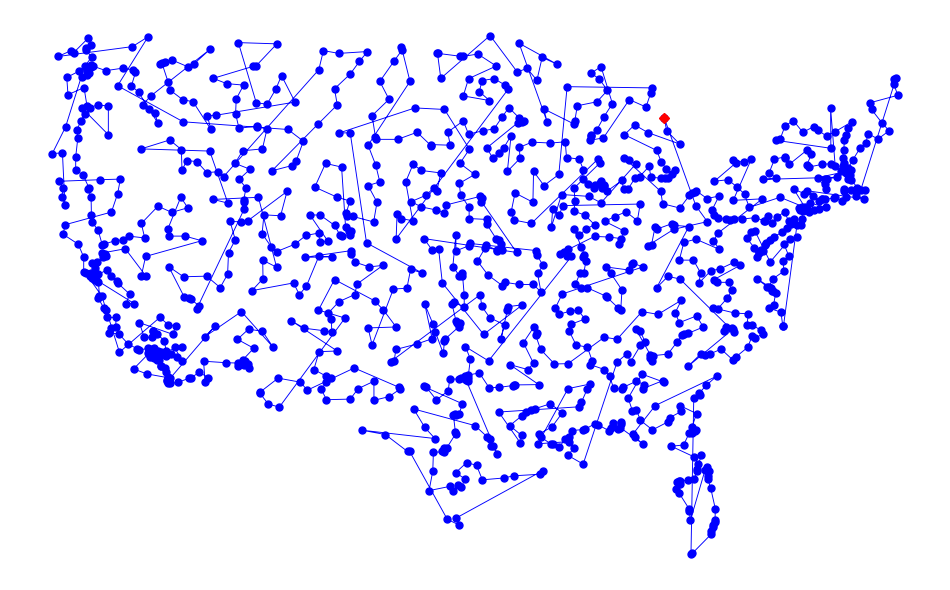

In [38]:
run(mst_tsp, USA)

Why would anyone want to use the minimum spanning tree algorithm, when the nearest neighbor algorithm is simpler to describe, simpler to implement, runs faster, and (at least on this one USA map) produces shorter tours? 

## Guaranteed Tour Length

The "giant" thing about the minimum spanning tree algorithm is that it comes with a *guarantee*, which none of the other algorithms offer (except for `exhaustive_tsp`, which is guaranteed to find the optimal algorithm, if it has enough time to complete). The algorithm  guarantees that the tour length will be no worse than twice as long as the optimal tour.  (And, with a bit more [complication](https://en.wikipedia.org/wiki/Christofides_algorithm), you can modify it to give a guarantee of 1.5 times longer.)  The guarantee works like this:

1. The minimum spanning tree, by definition, connects all the cities with the shortest possible total link length.
2. So if you could follow each link in the spanning tree just once, and that formed a legal tour, then that would be guaranteed to be
a minimal tour.  
3. But you can't do that in general; in general there will be places where you skip to the next city without following the spanning tree.  Any such skip, however, is a straight line, and thus will be less than you would take if you went to the next city by following along the spanning tree.
4. If you did follow along the spanning tree, you would follow some links twice, and some links once.  Hence the total length of the tour would be at most twice the spanning tree, and thus at most twice the minimal tour.

A guarantee is great from a theoretical point of view, but in practice the greedy or nearest neighbor algorithms almost always do better than the minimum spanning tree,  on the maps that we actually see. 

# Ensemble Strategy (k_nearest_tsp and ensemble_tsp)

So far we have seen several alternative TSP algorithms. We will; soon run benchmarks to determine which alorithm gives the shortest tours, on average. But even when we know that, I don't know how to predict which algorithm will give the shortest tour on a specific set of cities.  That suggests we try  the **ensemble strategy**: run multiple TSP algorithms and choose the best resulting tour. 

Here's an idea for a simple kind of ensemble: run the `nearest_tsp` algorithm *k* times with *k* different starting cities, and take the shortest resulting tour:

In [39]:
def k_nearest_tsp(cities, k=10):
    "Run nearest_tsp starting from k different cities; pick the shortest tour."
    start_cities = list(cities)[:k]
    return shortest(nearest_tsp(cities, start) for start in start_cities)

Here's an algorithm that tries *k* different start cities and chooses the shortest resulting tour:

k_nearest_tsp(1088 cities) ⇒ 51,509 length tour in 1,107 msecs

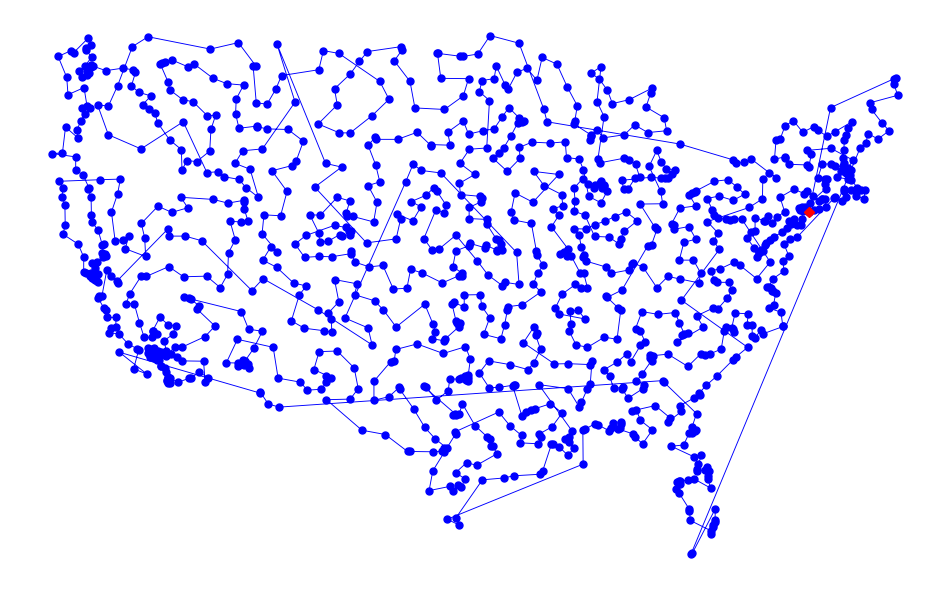

In [40]:
run(k_nearest_tsp, USA)

Next I'll make an ensemble of `k_nearest_tsp`, `greedy_tsp` and `mst_tsp`, apply two-opt to all the resulting tours, and select the shortest one:

In [41]:
ensemble_component_tsps = [compose(two_opt, tsp) for tsp in (k_nearest_tsp, greedy_tsp, mst_tsp)]

def ensemble_tsp(cities, tsps=ensemble_component_tsps): 
    "Apply an ensemble of algorithms to cities and take the shortest resulting tour."
    return shortest(tsp(cities) for tsp in tsps)

ensemble_tsp(1088 cities) ⇒ 44,417 length tour in 7,906 msecs

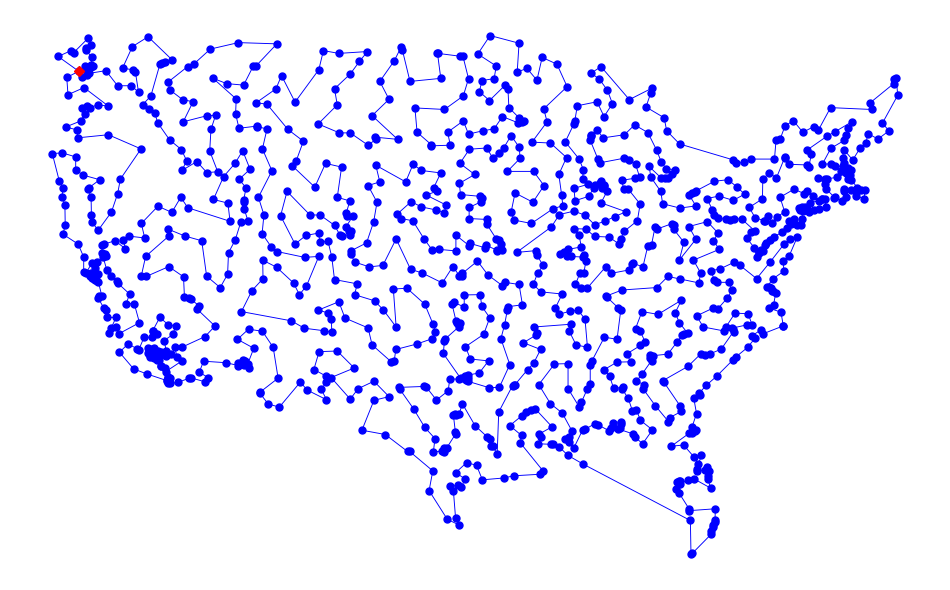

In [42]:
run(ensemble_tsp, USA)

# Shoulders of Giants: Held-Karp Algorithm: held_karp_tsp




| ![](http://imgs.xkcd.com/comics/travelling_salesman_problem.png) |
|----|
| [xkcd 399](http://xkcd.com/399/) |


Another algorithm that shows up with a literature search is the [Held-Karp Dynamic Programming Algorithm](http://en.wikipedia.org/wiki/Held%E2%80%93Karp_algorithm), named after giants [Michael Held](http://www.computerhistory.org/collections/catalog/102650390) and [Richard Karp](http://en.wikipedia.org/wiki/Richard_M._Karp). It is an algorithm for finding optimal tours, not approximate ones, so it is not appropriate for large *n*.  But even in its simplest form, without any complex programming tricks, it can go quite a bit further than `exhaustive_tsp`.  That is because `exhaustive_tsp` is O(*n*!), while the Held-Karp algorithm is only O(*n*<sup>2</sup> 2<sup>*n*</sup>).  How did Held and Karp achieve this speedup?  They noticed that `exhaustive_tsp` wastes a lot of time with permutations that can't possibly be optimal tours.  Here's the key idea:

- **Key idea**: *Given a start city A, an end city C, and a set of middle cities Bs, then out of all the possible segments that start in A, end in C, and go through all and only the cities in Bs, only the shortest of those segments could ever be part of an optimal tour.*

Of course, we don't know that the optimal tour goes through exactly those Bs cities before hitting C.  But if it does, then we need only consider the permutation of Bs that leads to the shortest segment.  Why is that such a big deal? Suppose we are considering segments of the form:

     [A, {B1, ... B10}, C, {D1, ... D10}, E]
     
That is, segments that start with A, then have have 10 B<sub>i</sub> cities in some order, then C, then 10 D<sub>j</sub> cities in some order, then E. With the Exhaustive Search algorithm, we have to consider all orderings of B<sub>i</sub> and all orderings of D<sub>j</sub>, so overall there would be (10!)<sup>2</sup> &approx; 13 trillion orderings of this form. But with Held-Karp, we consider the B<sub>i</sub> and D<sub>j</sub> separately, and chose the best segment from each, giving us only 2 &times; 10! &approx; 7 million orderings to consider. (Actually it is even better than that, because we use Held-Karp recursively to split the B<sub>i</sub> and D<sub>j</sub> into pieces.) 

So far we have only been talking about segments.  We know that the TSP is defined for tours, not segments. So even if we find the shortest possible segment, it might not be the shortest possible tour.  But here's something we do know: a tour has to end somewhere.  So we have:

- **Held-Karp algorithm**: *Find the shortest segment from the start city, `A`, to each possible end city, `C`, using the key idea above.   Out of those segments, choose the one that is the shortest tour.*

In [43]:
def held_karp_tsp(cities) -> Tour:
    """The Held-Karp shortest tour of this set of cities.
    For each end city C, find the shortest segment from A (the start) to C.
    Out of all these shortest segments, pick the one that is the shortest tour."""
    A = first(cities)
    shortest_segment.cache_clear() # Clear cache for a new problem
    return shortest(shortest_segment(A, cities - {A, C}, C)
                    for C in cities - {A})

# TO DO: shortest_segment(A, Bs, C)

Now for `shortest_segment(A, Bs, C)`, the shortest segment that starts in city `A`, ends in `C`, and visits some permutation of `Bs` cities in the middle.  If there are no `Bs` cities, then of course the shortest segment is to go directly from `A` to `C`.  If there are `Bs` cities, then one of them has to be the last `B` city visited (just before visiting `C`). So for each `B`, find the shortest segment that first goes from `A`, through all the other `Bs` cities, then to `B`, and finally to `C`.  Out of all these candidate segments, return the one with the minimum segment length.

**Note:** the decorator `@cache` makes this a **dynamic programming** algorithm, which is a fancy name meaning that we cache the results of sub-computations because we will re-use them multiple times. In the function `held_karp_tsp` we clear the cache at the start of each new problem.

In [44]:
@cache
def shortest_segment(A, Bs, C) -> Segment:
    "The shortest segment starting at A, going through all Bs, and ending at C."
    if not Bs:
        return [A, C]
    else:
        return min((shortest_segment(A, Bs - {B}, B) + [C] for B in Bs),
                   key=segment_length)
            
def segment_length(segment):
    "The total of distances between each pair of consecutive cities in the segment."
    # Same as tour_length, but without distance(tour[0], tour[-1])
    return sum(distance(segment[i], segment[i-1]) 
               for i in range(1, len(segment)))

That's all there is to it.  Let's try a run:

held_karp_tsp(10 cities) ⇒ 7,675 length tour in 32 msecs

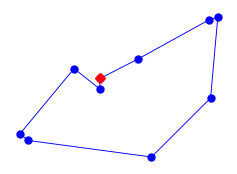

In [45]:
run(held_karp_tsp, random_cities(10))

exhaustive_tsp(10 cities) ⇒ 7,675 length tour in 1,160 msecs

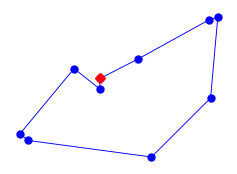

In [46]:
run(exhaustive_tsp, random_cities(10))

We see that `held_karp_tsp` is a lot faster.  We can extend into uncharted territory  beyond the reach of  `exhaustive_tsp`:

held_karp_tsp(15 cities) ⇒ 7,796 length tour in 2,383 msecs

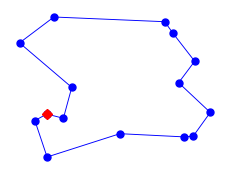

In [47]:
run(held_karp_tsp, random_cities(15))

Not bad! To see how much time we save using `held_karp_tsp` over `exhaustive_tsp`, we can extrapolate from the timings we've done, using the fact that Held-Karp is *O*(*n*<sup>2</sup> 2<sup>*n*</sup>) while Exhaustive Search is *O*(*n*!), to get this table:


|*n*|Exhaustive Search|Held Karp|
|---|---|---|
|10| 2 secs                | 0.04 secs |
|12|&approx; 4 mins   | 0.25 secs|
|15|&approx; 8 days |2 secs|
|25|&approx; <a href="https://www.google.com/search?q=2+seconds*25!+%2F+10!+in+years">270 billion years</a>|&approx; 95 minutes|



So if we had the patience to wait 95 minutes, `held_karp_tsp` could give us an answer on a 25-city problem that saves 270 billion years of computing compared to `exhaustive_tsp`.  The original Held-Karp algorithm had refinements that allowed it to handle 50-city sets in hours, not centuries, and could do so even with 1970s-era computing power! See **Branch and Cut** below.


# Review

Here are the algorithms we developed, grouped by strategy:f

- **Brute Force Strategy**: `exhaustive_tsp`
- **Greedy Strategy**: `nearest_tsp`, `greedy_tsp`
- **Ensemble Strategy**: `k_nearest_tsp`, `ensemble_tsp`
- **Local Search Strategy**: `two_opt`
- **Divide and Conquer Strategy**: `divide_tsp`
- **Giant Shoulders Strategy**: `mst_tsp`, `held_karp_tsp`

# Benchmarking

Which algorithm is best? I can't tell by trying them on only one or two problems. What I need to do is **benchmark** each algorithm on a standard **test set** of problems, and look at **statistical tests** to compare the algorithms. If the test set is large enough, the results will have statistical significance. If the test set is representative of the problems we want to solve, the results will have relevance. I'll build the following tools:
- `test_set`: A function to build a test set of random sets of cities.
- `Runs`: A data structure that holds the lengths and times of *n* runs by some TSP algorithm.
- `benchmark`: A function to run a single TSP algorithm on a test set.
- `benchmarks`: A function to run multiple TSP algorithmson a test set.
- `plot_benchmarks`: A function to plot the benchmark results of several algorithms.
- - `compare`: Easy way to call `benchmarks` and `plot_benchmarks` the result.

First the test sets:

In [48]:
TestSet = Tuple[Cities]

def test_set(num_sets: int, num_cities: int) -> TestSet:
    "Return `num_sets` different sets of `num_cities` random cities."
    return tuple(random_cities(num_cities, seed=i) for i in range(num_sets))

Next, the function `benchmark` takes as input a TSP function and a test set. It does a `run` of the function on each problem in the test set (possibly passing along `opt` and `kwds` values), and returns the list of `run` results. 

In [49]:
class Runs:
    """The tour lengths and run times of a TSP algorithm on a TestSet, with a pretty representation."""
    def __init__(self, runs, shortest=None):
        runs         = list(runs)
        self.name    = runs[0].name
        self.n       = len(runs[0].tour)
        self.lengths = [run.length for run in runs]
        self.shortest= shortest or mean(self.lengths)
        self.msecs   = [run.msec for run in runs]
    def __repr__(self):
        length = f"{mean(self.lengths):6,.0f} ± {stdev(self.lengths):5,.0f}"
        times  = f"{mean(self.msecs):3,.0f} ± {stdev(self.msecs):4.1f}"
        percent = f"({mean(self.lengths)/self.shortest:.2%})"
        return f"{self.name:>24}: {length} length {percent} in {times} msecs"
        
@cache
def benchmark(tsp: Callable, tests: TestSet) -> List[Runs]:
    "Benchmark a TSP algorithm on a test suite; return a Runs object."
    return Runs(run(tsp, test, plot=False) for test in tests)

def benchmarks(tsps: List[Callable], tests: TestSet, plot=True) -> List[List[Runs]]:
    "Benchmark a TSP algorithm on a test suite; return a list of Runs objects."
    results = [benchmark(tsp, tests) for tsp in tsps]
    shortest = min(mean(runs.lengths) for runs in results)
    for runs in results:
        runs.shortest = shortest
    return sorted(results, key=lambda run:mean(run.lengths))

In [50]:
def plot_benchmarks(list_of_runs: List[List[Run]]) -> List[List[Run]]:

    def plot(ax, offset, attr, color):
        matrix = [getattr(runs, attr) for runs in list_of_runs]
        xvals = [i + offset for i in range(len(list_of_runs))]
        ax.errorbar(x=xvals, y=mapl(mean, matrix), yerr=mapl(stdev, matrix), 
                    fmt='x', fillstyle=None, color=color, capsize=5)
        ax.scatter(x=3*xvals, y=(mapl(min, matrix) + mapl(max, matrix) + mapl(median, matrix)),
                    marker='_', color='dark'+color, zorder=3)
        ax.tick_params(axis='y', labelcolor=color)
        ax.tick_params(axis='x', rotation=45)
        ax.set_ylabel(attr, color=color, fontweight='bold')

    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax2      = ax1.twinx() # Second x axis (on right)
    ax1.set_xticks(range(len(list_of_runs)))
    ax1.set_xticklabels([runs.name for runs in list_of_runs])
    ax1.grid(True, linestyle=':', axis='y')
    offset = 0.07
    plot(ax1, -offset, 'lengths', 'slateblue')
    plot(ax2, +offset, 'msecs',   'orchid')
    return list_of_runs

def mapl(fn, iterable): return list(map(fn, iterable))

def compare(tsps, test_set): return plot_benchmarks(benchmarks(tsps, test_set))
    

# The Benchmarks

We'll start by comparing 4 algorithms on a test set of 30 sets of 300 cities each:

[              greedy_tsp: 37,128 ± 1,424 length (100.00%) in  15 ±  0.8 msecs,
            k_nearest_tsp: 38,740 ±   860 length (104.34%) in  75 ±  3.8 msecs,
              nearest_tsp: 40,472 ± 1,064 length (109.01%) in   9 ±  2.2 msecs,
                  mst_tsp: 43,127 ± 1,114 length (116.16%) in  24 ±  2.5 msecs]

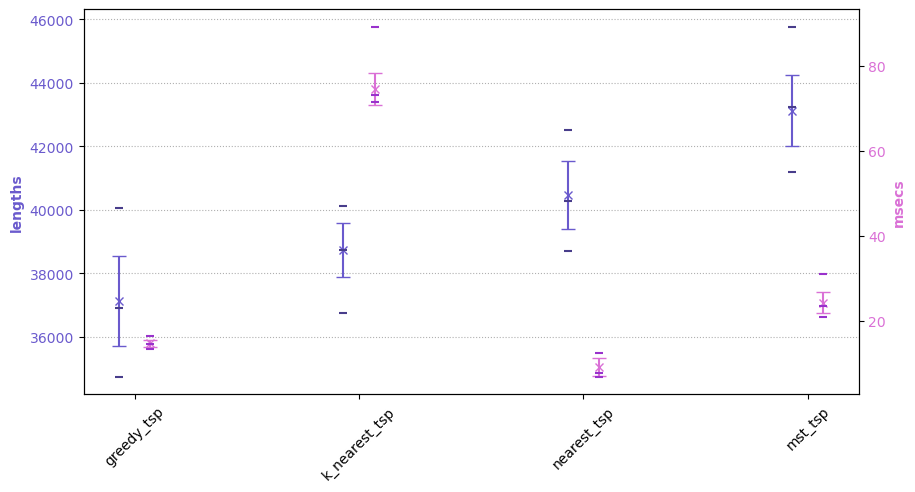

In [51]:
tsps  = [nearest_tsp, k_nearest_tsp, greedy_tsp, mst_tsp]
tests = test_set(30, 300)

compare(tsps, tests)

In [52]:
opt_tsps = [compose(two_opt, tsp) for tsp in tsps]

[      two_opt_greedy_tsp: 33,561 ±   663 length (100.00%) in 117 ± 20.8 msecs,
    two_opt_k_nearest_tsp: 34,178 ±   549 length (101.84%) in 187 ± 19.4 msecs,
      two_opt_nearest_tsp: 34,220 ±   779 length (101.96%) in 137 ± 34.2 msecs,
          two_opt_mst_tsp: 34,526 ±   671 length (102.87%) in 157 ± 33.0 msecs,
               greedy_tsp: 37,128 ± 1,424 length (110.63%) in  15 ±  0.8 msecs,
            k_nearest_tsp: 38,740 ±   860 length (115.43%) in  75 ±  3.8 msecs,
              nearest_tsp: 40,472 ± 1,064 length (120.59%) in   9 ±  2.2 msecs,
                  mst_tsp: 43,127 ± 1,114 length (128.50%) in  24 ±  2.5 msecs]

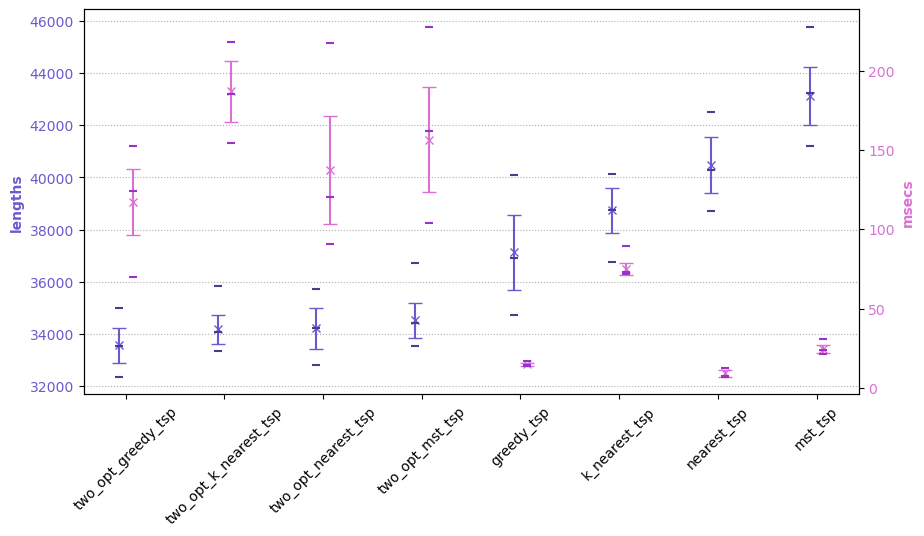

In [53]:
compare(tsps + opt_tsps, tests)

[            ensemble_tsp: 33,527 ±   638 length (100.00%) in 483 ± 50.2 msecs,
       two_opt_greedy_tsp: 33,561 ±   663 length (100.10%) in 117 ± 20.8 msecs,
    two_opt_k_nearest_tsp: 34,178 ±   549 length (101.94%) in 187 ± 19.4 msecs,
      two_opt_nearest_tsp: 34,220 ±   779 length (102.07%) in 137 ± 34.2 msecs,
          two_opt_mst_tsp: 34,526 ±   671 length (102.98%) in 157 ± 33.0 msecs,
               greedy_tsp: 37,128 ± 1,424 length (110.74%) in  15 ±  0.8 msecs,
            k_nearest_tsp: 38,740 ±   860 length (115.55%) in  75 ±  3.8 msecs,
              nearest_tsp: 40,472 ± 1,064 length (120.71%) in   9 ±  2.2 msecs,
                  mst_tsp: 43,127 ± 1,114 length (128.63%) in  24 ±  2.5 msecs]

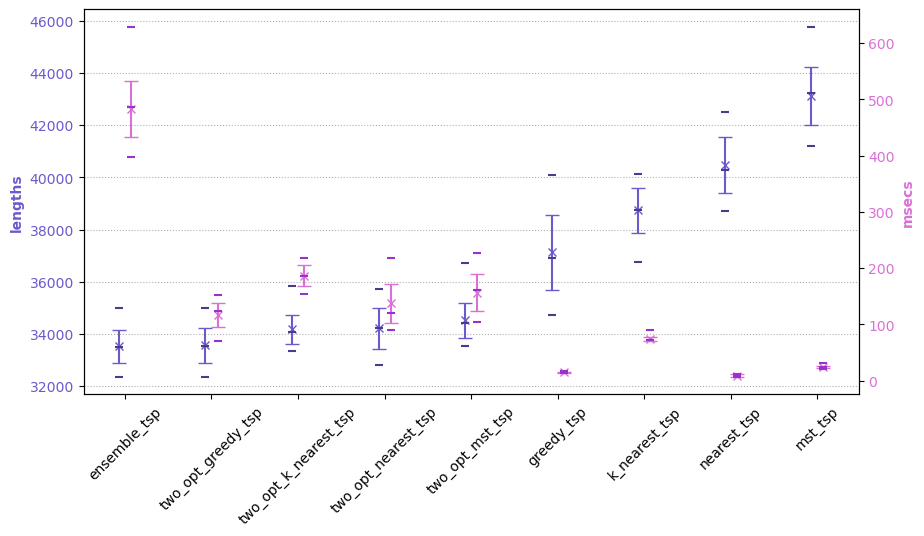

In [54]:
most_tsps = tsps + opt_tsps + [ensemble_tsp]

compare(most_tsps, tests)

This is interesting. Now `greedy_tsp` has increased its lead over `k_nearest_tsp`, and `divide_tsp` is out of contention. Apparently, it is hard for `two_opt` to optimize the types of tours produced by `divide_tsp`. On the other hand, `two_opt` seems to have an easy time optimizing `mst_tsp`.

As far as run time goes, note that `greedy_tsp` is now faster than `nearest_tsp`, reversing the previous comparison. It seems that `two_opt` runs faster on the tours produced by `greedy_tsp`. It should not be surprising that the speed of `two_opt` depends on the tour; `two_opt` has a `while` loop that will repeat a different number of times for different tours.

# Different Sizes of City Sets

Let's see if the results are different for different-sized city sets. We had been doing 30 samples of 300-city sets; let's try 20 samples of 500-city sets:

[            ensemble_tsp: 42,841 ±   544 length (100.00%) in 1,418 ± 158.3 msecs,
       two_opt_greedy_tsp: 42,885 ±   598 length (100.10%) in 398 ± 84.2 msecs,
    two_opt_k_nearest_tsp: 43,651 ±   553 length (101.89%) in 546 ± 51.3 msecs,
      two_opt_nearest_tsp: 43,798 ±   516 length (102.23%) in 394 ± 59.9 msecs,
          two_opt_mst_tsp: 44,422 ±   505 length (103.69%) in 465 ± 127.7 msecs,
               greedy_tsp: 47,939 ± 1,289 length (111.90%) in  65 ± 14.0 msecs,
            k_nearest_tsp: 49,545 ± 1,104 length (115.65%) in 203 ±  4.2 msecs,
              nearest_tsp: 51,182 ± 1,323 length (119.47%) in  21 ±  1.5 msecs,
                  mst_tsp: 55,371 ±   990 length (129.25%) in  77 ±  6.2 msecs]

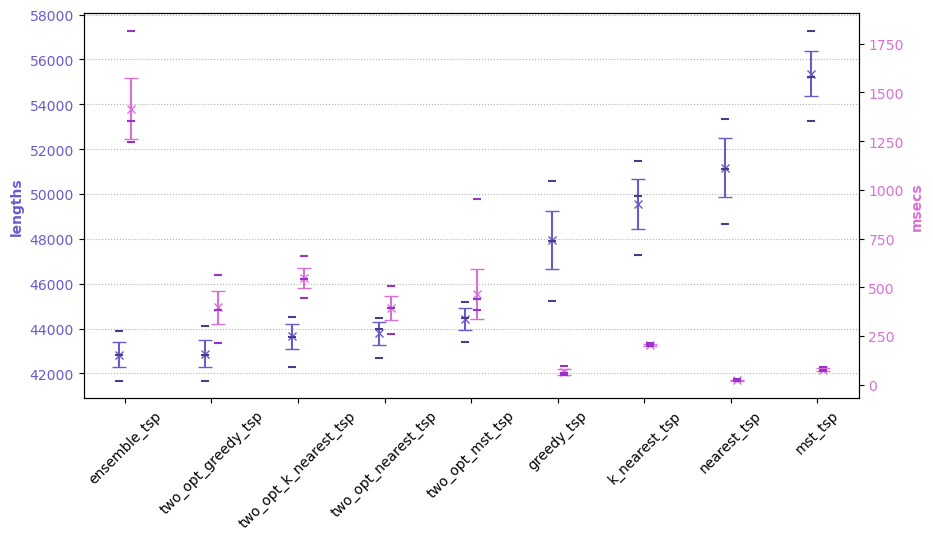

In [55]:
compare(most_tsps, test_set(20, 500))

At this size `greedy_tsp` is a more clear winner. 

# Benchmarking Exact Algorithms

Here I compare the two exact algorithms, Exhaustive Search and Held-Karp, to the (approximate) ensemble algorithm. I'll try both 9 and 10-city test suites:

[          exhaustive_tsp:  6,840 ±   708 length (100.00%) in 126 ± 59.9 msecs,
            held_karp_tsp:  6,840 ±   708 length (100.00%) in   8 ±  2.9 msecs,
             ensemble_tsp:  6,848 ±   709 length (100.11%) in   0 ±  0.1 msecs]

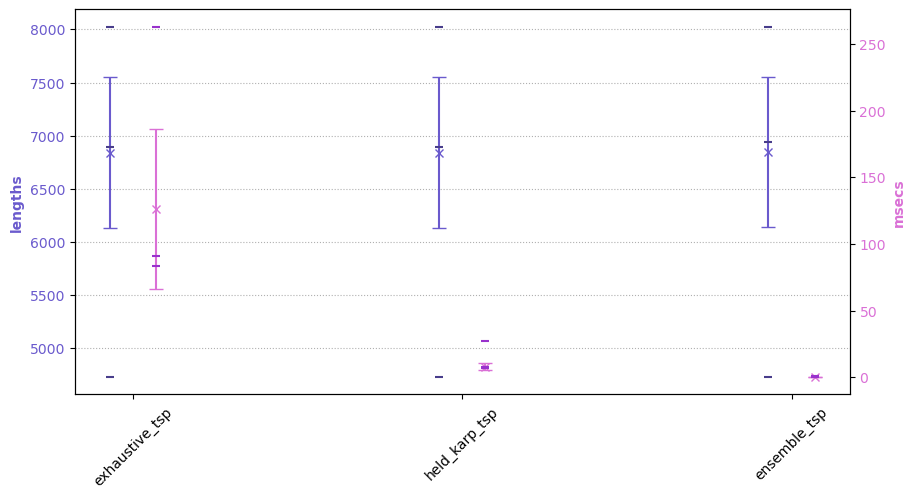

In [56]:
compare([exhaustive_tsp, held_karp_tsp, ensemble_tsp], test_set(50, 9))

In [57]:
benchmarks([held_karp_tsp, ensemble_tsp], test_set(30, 10))

[           held_karp_tsp:  7,233 ±   825 length (100.00%) in  26 ± 14.1 msecs,
             ensemble_tsp:  7,239 ±   821 length (100.07%) in   0 ±  0.1 msecs]

In [58]:
benchmarks([held_karp_tsp, ensemble_tsp], test_set(10, 16))

[           held_karp_tsp:  8,119 ±   699 length (100.00%) in 5,268 ± 94.6 msecs,
             ensemble_tsp:  8,119 ±   699 length (100.00%) in   1 ±  0.1 msecs]

This says that while `ensemble_tsp` does not give a guarantee of an optimal tour, in practice on small random city sets it performs almost as well as the exact algorithm (within 0.1%), only much faster.


# Further Explorations


That's all I'm going to write for now.  But there are still plenty of open questions for you to explore:

* **Branch and Cut**: this is a technique to cut off a search early, when a partial solution is obviously not optimal.  We saw how Held-Karp cuts off some permutations of cities when another permutation is better.  A refinement on that is to keep track of, say, the best total length of the segment going through all the Bs cities.  Then, any time you have a partial segment through some of the Bs cities that exceeds the best total, we can stop right there, before even finishing all the Bs.  With this technique, you can find optimal tours for around 50 cities.
* **Linear programming**: Look up the topic "linear programming" and see how it applies to TSP.
* **Heuristic Algorithms**: There are many approaches for using heurisitic estimates to find good (but not optimal) tours.  For example, *ant colony optimization algorithms* make random choices of which link to follow, and then the links that occur in the best tours get reinforced with some virtual pheromones, and other ants tend to follow those pheromones. *Simulated annealing* takes its inspiration from metallurgy.
* The **[Lin-Kernighan heuristic](http://akira.ruc.dk/~keld/research/LKH/LKH-1.3/DOC/LKH_REPORT.pdf)** is a generalization of `two_opt` that can split the tour into more than two pieces, and considers all ways to put it back together. With such tricks, approximate algorithms  can handle hundreds of thousands of cities and come within 0.01% of the shortest possible tour.
* The **[Christofides algorithm](https://en.wikipedia.org/wiki/Christofides_algorithm)** gives a guarantee of 3/2 the optimal tour length (improving on the minimum-spanning-tree guarantee of 2).
* Can you explain why `mst_tsp` produces a guaranteed result, while `greedy_tsp` does not, even though the two algorithms have similar structure in the way they iterate over `shortest_links_first`?
* The code in this notebook was designed for clarity, not efficiency.  Can you make the code faster? As one example, you could use a bit mask to represent a set of cities in Held-Karp; that should make a big difference.
* **[William Cook](https://www.math.uwaterloo.ca/~bico/)** has a comprehensive 
[web page](http://www.math.uwaterloo.ca/tsp/) on the TSP, as well as a great 
[book](https://press.princeton.edu/titles/9531.html) and a
[draft chapter](http://www.math.uwaterloo.ca/~bico/papers/comp_chapter1.pdf) on Discrete Optimization featuring TSP. Like my notebook here, Cook's chapter goes through a variety of algorithms for TSP, describing each one in prose and code. His coding style is different because he uses C (in an imperative style) while I used Python (in a mostly functional style).  His code is much more efficient (but if it is 100 times faster, that might only mean two more cities on `exhaustive_tsp`). Cook  chooses a different set of algorithms to explore, with
more emphasis on optimizing algorithms that find guaranteed shortest tours. I find his explanations and code
are both beautiful and concise, and I think it is very interesting that
there can be two quite different approaches, which (in my opinion) both turn out very well. 
* If you are heavily into math, there's a [taxonomy](http://cstheory.stackexchange.com/questions/9241/approximation-algorithms-for-metric-tsp) of solutions.
* What else are you interested in?